In [1]:
# imports
import os

import torch
from DataHandlers import *
from NN_model import *
from Trainers import *
from Utils import *
from demo_exp_params import *
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

tmp_result_dir_exist = os.path.exists("./tmp_results")
if not tmp_result_dir_exist:
   # Create a tmp_results dir because it does not exist
   os.makedirs("./tmp_results")

Using device cuda:0


# Toy problem

## Data
### Setup
For GT generation, we generate a video of two microtubules crossed using DBlink code. Base spatial resolution 128x128 pixels, temporal resolution 20 FPS and length N frames. Then we upsample the video with a factor of 2 by applying movement to the structure. We add $sin(t\frac{\pi}{2})$ for $t=0...N-1$ to the X coordinates of the structure.

To obtain HSLT, we drop every second frame of the GT video. HSLT video has spatial resolution 128x128 pixels, temporal resolution 10 FPS (length N/2 frames).

For LSHT, we apply downscaling by summing pixel regions. LSHT video has spatial resolution 64x64 pixels, temporal resolution 20 FPS (length N frames).

### Goal
The intended fusion reconstruction should be able to provide high spatial details in the area where the microtubules cross, as well as demonstrate the fluctuating movement which is not present in HSLT video.

In [2]:
X_test = torch.load('X_test')
y_test = torch.load('y_test')

In [5]:
X_test.squeeze().shape

torch.Size([4, 150, 128, 128])

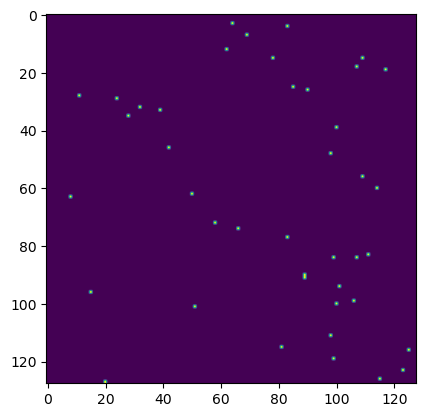


KeyboardInterrupt



In [16]:
for i in range(X_test.squeeze().shape[1]):
    clear_output()
    plt.imshow(X_test.squeeze()[0,i])
    plt.show()
    sleep(0.5)

In [19]:
for i in range(y_test.squeeze().shape[1]):
    clear_output()
    plt.imshow(y_test.squeeze()[0,i])
    plt.show()
    sleep(0.1)


KeyboardInterrupt



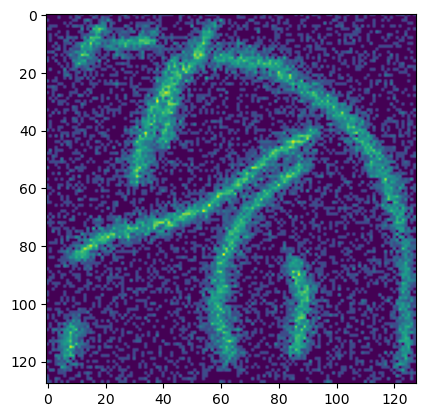

In [3]:
plt.imshow(X_test[1].std(0).squeeze())

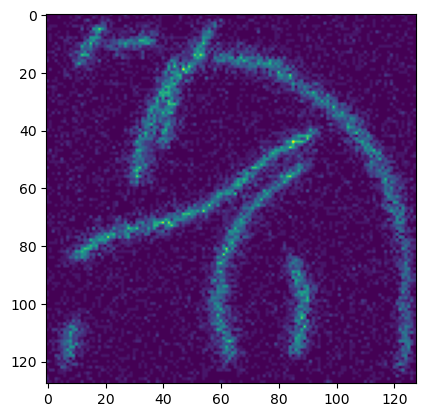

In [4]:
plt.imshow(X_test[1].mean(0).squeeze())

In [33]:
X = X_test[1].squeeze()
y = y_test[1].squeeze()

In [37]:
X.shape

torch.Size([150, 128, 128])

In [43]:
torch.conv1d(X, torch.ones(30,1,1)).shape

RuntimeError: Given groups=1, weight of size [30, 1, 1], expected input[150, 128, 128] to have 1 channels, but got 128 channels instead

In [48]:
import torch.nn.functional as F

# Step 2: Define the window size and step
window_size = 30
step = 1

# Step 3: Reshape X to 4D for unfolding
X_reshaped = X.unsqueeze(0)  # Add batch and channel dimensions

# Step 4: Use unfold to create sliding windows
# unfold function parameters: kernel_size, dilation, padding, stride
windows = F.unfold(X_reshaped, (window_size), stride=(step))

# Step 5: Sum over the windows
output = windows.view(window_size, -1, 128 * 128).sum(dim=0)

# Step 6: Reshape the output to the desired shape
output = output.view(-1, 128, 128)

print("Output shape:", output.shape)
print("Output tensor:", output)

RuntimeError: shape '[30, -1, 16384]' is invalid for input of size 1323135000

In [56]:
arr_out = np.apply_along_axis(
                lambda x: np.convolve(x, torch.ones(30), mode = 'valid'), 
                axis = 0, arr = X)

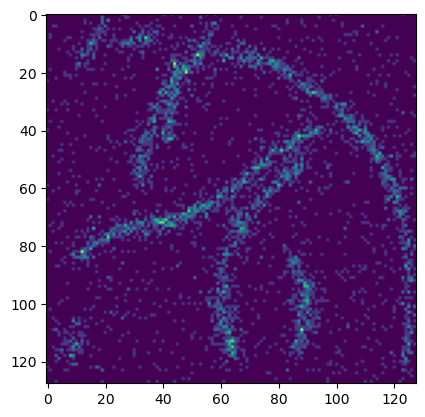

KeyboardInterrupt: 

In [58]:
for s in arr_out:
    clear_output()
    plt.imshow(s)
    plt.show()
    sleep(0.25)

## Methods
Types of problem setups:
- Type 1: Temporally 1:2, spatially misscaled, noised
- Type 2: Temporally 1:1, spatially misscaled, noised
- Type 3: Temporally 1:1, spatially 1:1, noised
- Type 4: Temporally 1:1, spatially 1:1, denoised

Fusion methods considered:
- SPAD CMOS fusion: Type 1, MATLAB code, needs to be adapted to our problem statement, 4 years old
  Uses LR Time-of-Flight images and HR Integrated CCD images, therefore has a prior for temporal integration
- Multi-resolution Data Fusion (MDF): Not exactly the same, but could be applied as Type 1, Python code, 3 years old
  Uses wide FOV LR image and a few HR images, learns complex forward dynamics and multi-agent agreement for fusion, might be too complex and for the problem that is not exactly the same
- IFCNN: Type 3, Python code, 5 years old
  Applied on multi-focus pairs of images, uses spatial features to merge the best of the two; but we want to fuse spatial and temporal information.

We will consider SPAD CMOS fusion approach as it seems the most relevant and applicable.